Author: Tyler Chase

Date: 2017/05/18

# Milestone Model Subreddit Classification

This code uses a classification model to classify an image to one of 20 subreddits. For the sake of the milestone we implement an Alex Net model and analyze the results. 

## Model Helper Functions

These functions serve to determine the size of outputs to common neural network layers. 

In [1]:
# Gets height and width dimensions of ouput of convolution layer with height H, width W, etc.
def get_conv_output_dim(H, W, conv_stride, filter_height, filter_width, padding_method):
    # Referenced http://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t
    if padding_method == 'VALID':
        conv_output_height = np.ceil(float(H - filter_height + 1) / float(conv_stride))
        conv_output_width = np.ceil(float(W - filter_width + 1) / float(conv_stride))
    elif padding_method == 'SAME':
        conv_output_height = np.ceil(float(H) / float(conv_stride))
        conv_output_width = np.ceil(float(W) / float(conv_stride))
    return (int(conv_output_height), int(conv_output_width))

# Gets dimensions of output for the pooling layer
def get_pool_dim(H, W, ksize_height, ksize_width, pool_stride, padding_method):
    # Same calculation as convolution layer
    return get_conv_output_dim(H, W, ksize_height, ksize_width, pool_stride, padding_method)

## Load Datasets

In [21]:
import tensorflow as tf
import numpy as np
import math
import timeit
import random
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [25]:
# Load data and split into training validation and testing sets

# Function for permuting and splitting data into training, developement, and test
def import_dataset(address, file_names, train_percent = 80, dev_percent = 10):
    SEED = 455
    random.seed(SEED)
    # Read csv file and create a list of tuples
    images = np.load(address+file_names['images'])
    images = images.astype(float)
    with open(address + file_names['subs'], 'rb') as file_2:
        subs = pickle.load(file_2)
        subs = np.array(subs)
    with open(address + file_names['dict'], 'rb') as file_3:
        dictionary = pickle.load(file_3)
    # Mix data and split into tran, dev, and test sets
    N,W,H,C = np.shape(images)
    indices = np.arange(N)
    random.shuffle(indices)
    images = images[indices]
    subs = subs[indices]
    train_end = int(train_percent*N/100)
    dev_end = train_end + int(dev_percent*N/100)
    X_train = images[:train_end]
    y_train = subs[:train_end]
    X_val = images[train_end:dev_end]
    y_val = subs[train_end:dev_end]
    X_test = images[dev_end:]
    y_test = subs[dev_end:]
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    return X_train, y_train, X_val, y_val, X_test, y_test, dictionary

# Form training, developement, and testing data sets
address = r'/Users/tylerchase/Documents/Stanford_Classes/CS231n_CNN_for_Visual_Recognition/final_project/milestoneData/Archive//'
file_names = {}
file_names['images'] = 'final_output_data.npy'
file_names['subs'] = 'final_output_labels'
file_names['dict'] = 'final_output_subredditIndex'
X_train, y_train, X_val, y_val, X_test, y_test, dictionary = import_dataset(address, file_names)

# Print the sizes as a sanity check
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Train data shape:  (18569, 128, 128, 3)
Train labels shape:  (18569,)
Validation data shape:  (2321, 128, 128, 3)
Validation labels shape:  (2321,)
Test data shape:  (2322, 128, 128, 3)
Test labels shape:  (2322,)


## Define AlexNet model 

* 11x11 convolutional layer with 96 filters and a stride of 4
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 5x5 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation
* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation 
* 3x3 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2


* affine layer from 4096 to 1792
* ReLU activation
* affine layer from 1792 to 1792
* ReLU activation
* affine layer from 1792 to 20

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 128, 128, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
Ncategories = 20

def AlexNet(X, y, is_training):
    # define our weights (e.g. init_two_layer_convnet)
    
    # Convolutional Variables
    Wconv1 = tf.get_variable("Wconv1", shape=[11, 11, 3, 96])
    bconv1 = tf.get_variable("bconv1", shape=[96])
    Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 96, 256])
    bconv2 = tf.get_variable("bconv2", shape=[256])
    Wconv3 = tf.get_variable("Wconv3", shape=[3, 3, 256, 384])
    bconv3 = tf.get_variable("bconv3", shape=[384])
    Wconv4 = tf.get_variable("Wconv4", shape=[3, 3, 384, 384])
    bconv4 = tf.get_variable("bconv4", shape=[384])
    Wconv5 = tf.get_variable("Wconv5", shape=[3, 3, 384, 256])
    bconv5 = tf.get_variable("bconv5", shape=[256])
    
    # Fully Connected Variables
    W1 = tf.get_variable("W1", shape=[4096, 1792])
    b1 = tf.get_variable("b1", shape=[1792])
    W2 = tf.get_variable("W2", shape=[1792, 1792])
    b2 = tf.get_variable("b2", shape=[1792])
    W3 = tf.get_variable("W3", shape=[1792, Ncategories])
    b3 = tf.get_variable("b3", shape=[Ncategories])

    # define our graph (e.g. AlexNet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,4,4,1], padding='SAME') + bconv1       #Out N/4 x N/4
    h1 = tf.nn.relu(a1)
    mp1 = tf.nn.max_pool(h1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')   #Out N/2 x N/2
    bn1 = tf.layers.batch_normalization(mp1, training=is_training)
        
    a2 = tf.nn.conv2d(bn1, Wconv2, strides=[1,1,1,1], padding='SAME') + bconv2     #Out N x N
    h2 = tf.nn.relu(a2)
    mp2 = tf.nn.max_pool(h2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')   #Out N/2 x N/2
    bn2 = tf.layers.batch_normalization(mp2, training=is_training)              
    
    a3 = tf.nn.conv2d(bn2, Wconv3, strides=[1,1,1,1], padding='SAME') + bconv3     #Out N x N
    h3 = tf.nn.relu(a3)
    a4 = tf.nn.conv2d(h3, Wconv4, strides=[1,1,1,1], padding='SAME') + bconv4      #Out N x N
    h4 = tf.nn.relu(a3)
    a5 = tf.nn.conv2d(h4, Wconv5, strides=[1,1,1,1], padding='SAME') + bconv5      #Out N x N
    h5 = tf.nn.relu(a5)
    mp3 = tf.nn.max_pool(h5, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')   #Out N/2 x N/2
    
    mp_flat = tf.reshape(mp3,[-1,4096])
    aff1 = tf.matmul(mp_flat, W1) + b1
    h6 = tf.nn.relu(aff1)
    aff2 = tf.matmul(h6, W2) + b2
    h7 = tf.nn.relu(aff2)
    y_out = tf.matmul(h7, W3) + b3
    
    return y_out

# Define y_out in graph
y_out = AlexNet(X, y, is_training)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,Ncategories),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

## Test the Size of Your Output as Sanity Check

Input random numbers into X for feed dictionary and check the size of the output makes sense. 

In [4]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 128, 128,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 20])))

(64, 20)
True


## Train the Model

Training
Iteration 0: with minibatch training loss = 1.12 and accuracy of 0.047
Iteration 1: with minibatch training loss = 0.331 and accuracy of 0.047
Iteration 2: with minibatch training loss = 0.344 and accuracy of 0.078
Iteration 3: with minibatch training loss = 0.304 and accuracy of 0.047
Iteration 4: with minibatch training loss = 0.298 and accuracy of 0.047
Iteration 5: with minibatch training loss = 0.204 and accuracy of 0.047
Iteration 6: with minibatch training loss = 0.194 and accuracy of 0.078
Iteration 7: with minibatch training loss = 0.185 and accuracy of 0.031
Iteration 8: with minibatch training loss = 0.147 and accuracy of 0.062
Iteration 9: with minibatch training loss = 0.152 and accuracy of 0.14
Iteration 10: with minibatch training loss = 0.155 and accuracy of 0.062
Iteration 11: with minibatch training loss = 0.156 and accuracy of 0.031
Iteration 12: with minibatch training loss = 0.138 and accuracy of 0.062
Iteration 13: with minibatch training loss = 0.143 and

Iteration 114: with minibatch training loss = 0.106 and accuracy of 0.16
Iteration 115: with minibatch training loss = 0.108 and accuracy of 0.14
Iteration 116: with minibatch training loss = 0.108 and accuracy of 0.12
Iteration 117: with minibatch training loss = 0.106 and accuracy of 0.19
Iteration 118: with minibatch training loss = 0.106 and accuracy of 0.11
Iteration 119: with minibatch training loss = 0.106 and accuracy of 0.16
Iteration 120: with minibatch training loss = 0.106 and accuracy of 0.12
Iteration 121: with minibatch training loss = 0.107 and accuracy of 0.094
Iteration 122: with minibatch training loss = 0.108 and accuracy of 0.14
Iteration 123: with minibatch training loss = 0.107 and accuracy of 0.078
Iteration 124: with minibatch training loss = 0.108 and accuracy of 0.16
Iteration 125: with minibatch training loss = 0.106 and accuracy of 0.16
Iteration 126: with minibatch training loss = 0.107 and accuracy of 0.12
Iteration 127: with minibatch training loss = 0.1

Iteration 227: with minibatch training loss = 0.107 and accuracy of 0.19
Iteration 228: with minibatch training loss = 0.107 and accuracy of 0.2
Iteration 229: with minibatch training loss = 0.106 and accuracy of 0.14
Iteration 230: with minibatch training loss = 0.104 and accuracy of 0.28
Iteration 231: with minibatch training loss = 0.105 and accuracy of 0.19
Iteration 232: with minibatch training loss = 0.105 and accuracy of 0.22
Iteration 233: with minibatch training loss = 0.104 and accuracy of 0.28
Iteration 234: with minibatch training loss = 0.106 and accuracy of 0.23
Iteration 235: with minibatch training loss = 0.106 and accuracy of 0.22
Iteration 236: with minibatch training loss = 0.107 and accuracy of 0.17
Iteration 237: with minibatch training loss = 0.106 and accuracy of 0.17
Iteration 238: with minibatch training loss = 0.109 and accuracy of 0.14
Iteration 239: with minibatch training loss = 0.105 and accuracy of 0.19
Iteration 240: with minibatch training loss = 0.107 

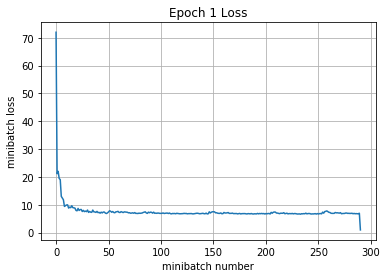

Iteration 291: with minibatch training loss = 0.107 and accuracy of 0.19
Iteration 292: with minibatch training loss = 0.108 and accuracy of 0.16
Iteration 293: with minibatch training loss = 0.106 and accuracy of 0.23
Iteration 294: with minibatch training loss = 0.107 and accuracy of 0.14
Iteration 295: with minibatch training loss = 0.106 and accuracy of 0.22
Iteration 296: with minibatch training loss = 0.106 and accuracy of 0.17
Iteration 297: with minibatch training loss = 0.105 and accuracy of 0.2
Iteration 298: with minibatch training loss = 0.105 and accuracy of 0.2
Iteration 299: with minibatch training loss = 0.106 and accuracy of 0.078
Iteration 300: with minibatch training loss = 0.105 and accuracy of 0.2
Iteration 301: with minibatch training loss = 0.107 and accuracy of 0.12
Iteration 302: with minibatch training loss = 0.105 and accuracy of 0.16
Iteration 303: with minibatch training loss = 0.105 and accuracy of 0.19
Iteration 304: with minibatch training loss = 0.105 a

Iteration 404: with minibatch training loss = 0.104 and accuracy of 0.23
Iteration 405: with minibatch training loss = 0.105 and accuracy of 0.28
Iteration 406: with minibatch training loss = 0.105 and accuracy of 0.23
Iteration 407: with minibatch training loss = 0.105 and accuracy of 0.22
Iteration 408: with minibatch training loss = 0.103 and accuracy of 0.22
Iteration 409: with minibatch training loss = 0.104 and accuracy of 0.27
Iteration 410: with minibatch training loss = 0.106 and accuracy of 0.22
Iteration 411: with minibatch training loss = 0.105 and accuracy of 0.23
Iteration 412: with minibatch training loss = 0.103 and accuracy of 0.36
Iteration 413: with minibatch training loss = 0.101 and accuracy of 0.33
Iteration 414: with minibatch training loss = 0.102 and accuracy of 0.27
Iteration 415: with minibatch training loss = 0.103 and accuracy of 0.3
Iteration 416: with minibatch training loss = 0.102 and accuracy of 0.27
Iteration 417: with minibatch training loss = 0.105 

KeyboardInterrupt: 

In [5]:
# Run the model returning total loss and total correct
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,1,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Run the Model on the Training and Validation Data

In [6]:
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.102 and accuracy of 0.246
Validation
Epoch 1, Overall loss = 0.103 and accuracy of 0.24


(0.10273629350877435, 0.23955191727703576)

## Run the Model on the Test Data

This is done only once after determining hyperparameters on the developement set. 

In [7]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 0.102 and accuracy of 0.249


(0.1024319133516738, 0.24892334194659776)

## Output Predictions for Validation 

In [11]:
y_val_pred = sess.run(y_out, {X: X_val, y: y_val, is_training: 0})

y_val_pred = np.argmax(y_val_pred, axis = 1)

## Plot Confusion Matrix for Subreddit Classification

Normalized confusion matrix


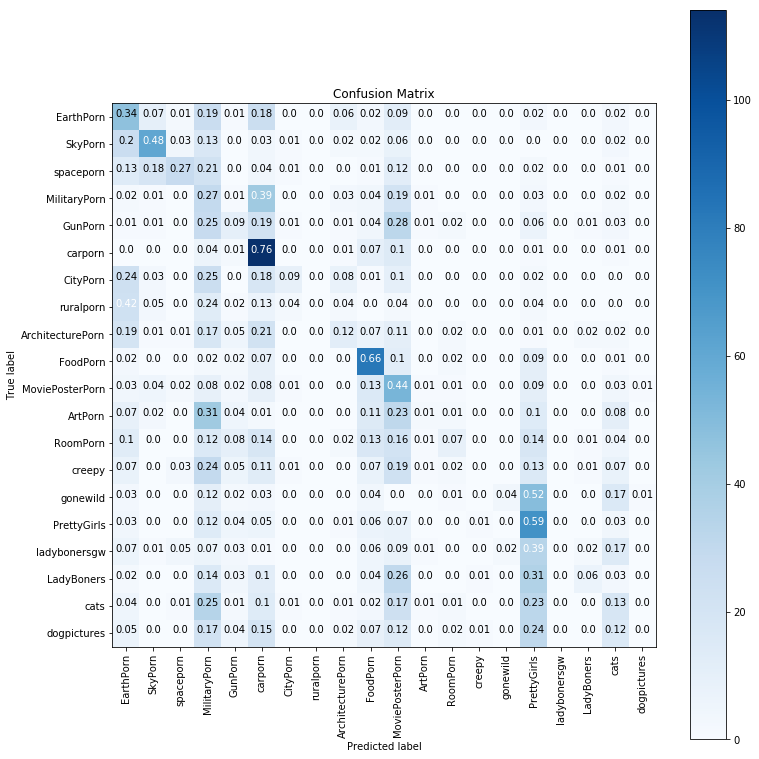

In [31]:
# Code to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues,
                          save_address = ''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(11,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #plt.savefig(save_address + 'confusion_mat.png')

classes = [""] * len(dictionary)
for sub, ind in dictionary.items():
    classes[ind] = sub

conf = confusion_matrix(y_val, y_val_pred)
plot_confusion_matrix(conf, classes=classes, normalize = True)
